Epoch 0: loss = 0.68270
Epoch 200: loss = 0.10666
Epoch 400: loss = 0.00247
Epoch 600: loss = 0.00046
Epoch 800: loss = 0.00023
Epoch 1000: loss = 0.00046
Epoch 1200: loss = 0.00008
Epoch 1400: loss = 0.00006
Epoch 1600: loss = 0.00005
Epoch 1800: loss = 0.00004
Epoch 2000: loss = 0.00003
Epoch 2200: loss = 0.00006
Epoch 2400: loss = 0.00002
Epoch 2600: loss = 0.00002
Epoch 2800: loss = 0.00002


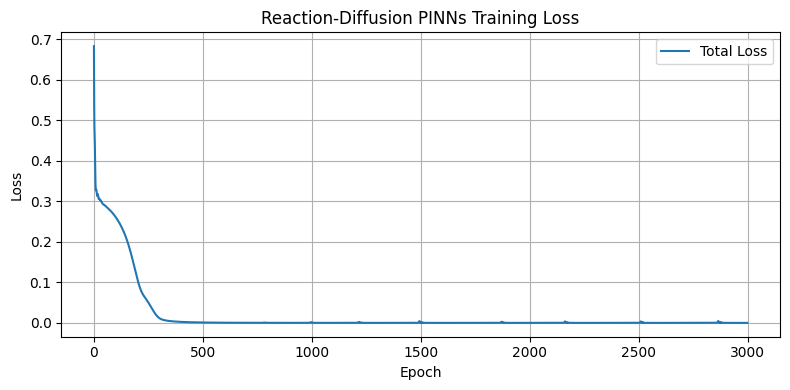

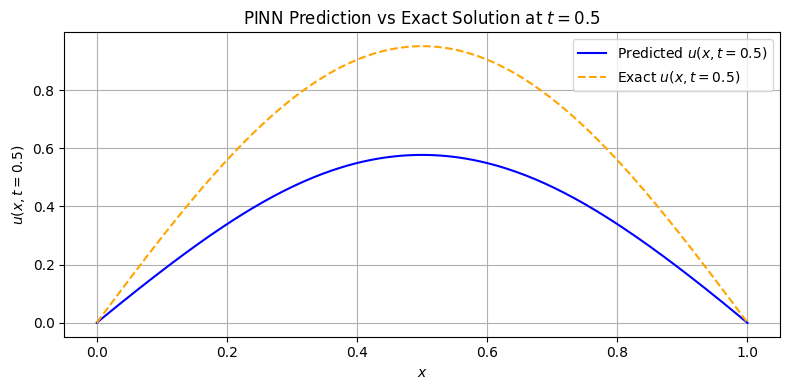

<Figure size 800x500 with 0 Axes>

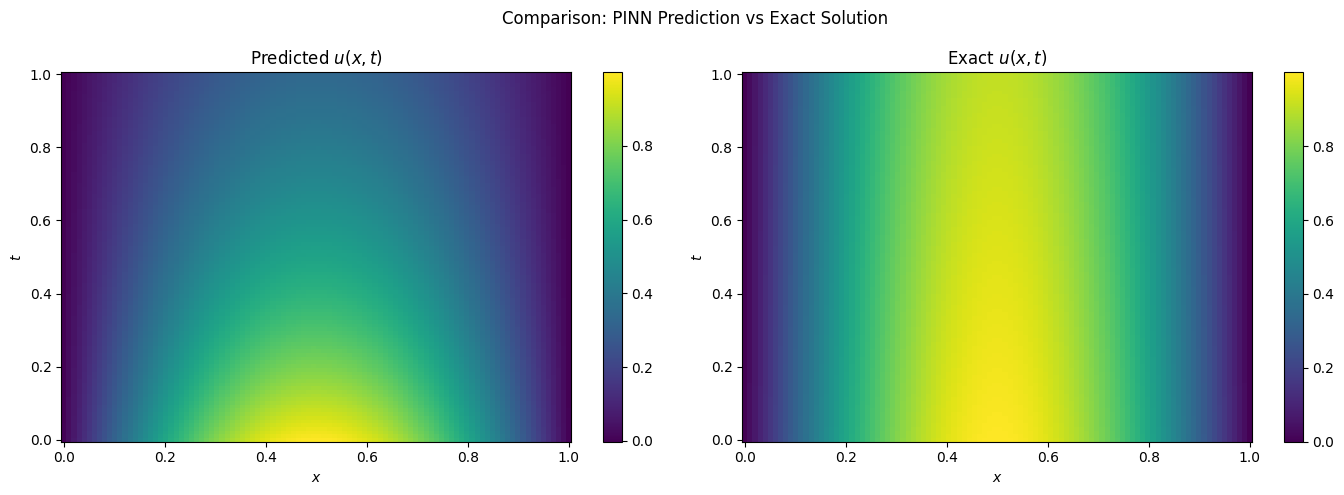

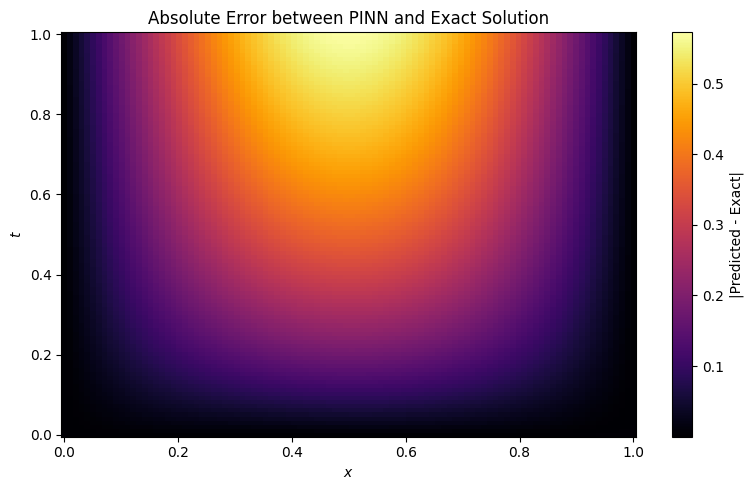

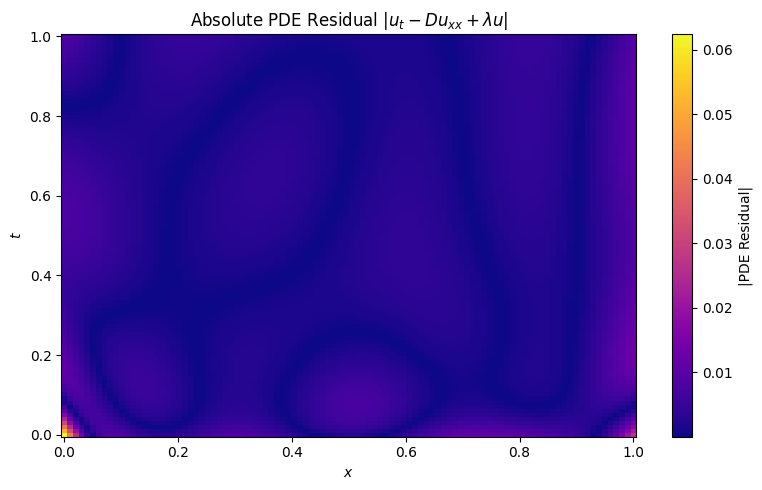

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# ----------------------------
# Part 1: Define PINN architecture
# ----------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# ----------------------------
# Part 2: Sample training points
# ----------------------------
N_f, N_i, N_b = 1000, 500, 100

# Collocation points for PDE
x_f = torch.rand(N_f, 1, requires_grad=True)
t_f = torch.rand(N_f, 1, requires_grad=True)

# Initial condition:
x_i = torch.rand(N_i, 1)
t_i = torch.zeros_like(x_i)
u_i = torch.sin(np.pi * x_i)

# Boundary condition: u(0,t) = u(1,t) = 0
t_b = torch.rand(N_b, 1)
x_b0 = torch.zeros_like(t_b)
x_b1 = torch.ones_like(t_b)

# ----------------------------
# Part 3: Define loss function (with λ1, λ2, λ3 weights)
# ----------------------------
def loss_fn(model, x_f, t_f, x_i, t_i, u_i, x_b0, x_b1, t_b, lambda1=1.0, lambda2=1.0, lambda3=1.0):
    x_f.requires_grad = True
    t_f.requires_grad = True

    u = model(x_f, t_f)
    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    D = 0.01
    lam = 1.0
    f = u_t - D * u_xx + lam * u
    loss_f = torch.mean(f ** 2)  # PDE residual loss

    loss_i = torch.mean((model(x_i, t_i) - u_i) ** 2)  # Initial condition loss
    loss_b = torch.mean(model(x_b0, t_b) ** 2) + torch.mean(model(x_b1, t_b) ** 2)  # Boundary condition loss

    return lambda1 * loss_f + lambda2 * loss_i + lambda3 * loss_b

# ----------------------------
# Part 4: Training loop
# ----------------------------
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []

for epoch in range(3000):
    optimizer.zero_grad()
    loss = loss_fn(model, x_f, t_f, x_i, t_i, u_i, x_b0, x_b1, t_b,
                   lambda1=1.0, lambda2=1.0, lambda3=1.0)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.5f}")

# ----------------------------
# Part 5: Plot training loss
# ----------------------------
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Reaction-Diffusion PINNs Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Part 6.1 (revised): Compare prediction vs exact solution on the same plot
# ----------------------------

# Choose a fixed time slice t = 0.5 to compare u(x, t)
t_fixed = 0.5
x_line = torch.linspace(0, 1, 200).reshape(-1, 1)
t_line = torch.full_like(x_line, t_fixed)

# Predict u(x, t_fixed) using the trained PINN
with torch.no_grad():
    u_pred_line = model(x_line, t_line).squeeze()

# Define the exact solution (for comparison)
# Here we use the classical solution: u(x, t) = exp(-π² D t) * sin(π x)
D = 0.01
def ground_truth_u(x, t):
    return torch.exp(-np.pi**2 * D * t) * torch.sin(np.pi * x)

# Compute the ground truth at the same x, t points
with torch.no_grad():
    u_exact_line = ground_truth_u(x_line, t_line).squeeze()

# Plot both predicted and exact solution on the same figure
plt.figure(figsize=(8, 4))
plt.plot(x_line.numpy(), u_pred_line.numpy(), label='Predicted $u(x, t=0.5)$', color='blue')
plt.plot(x_line.numpy(), u_exact_line.numpy(), label='Exact $u(x, t=0.5)$', color='orange', linestyle='--')
plt.xlabel('$x$')
plt.ylabel('$u(x, t=0.5)$')
plt.title('PINN Prediction vs Exact Solution at $t=0.5$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# Part 6.1: Compare Prediction vs Ground Truth
# ----------------------------

# Define ground truth (exact) solution if known
# Here we use an example ground truth: u(x,t) = exp(-π² D t) * sin(π x)
# This is a standard solution for u_t = D u_xx with initial condition u(x,0) = sin(πx), zero boundary
def ground_truth_u(x, t):
    D = 0.01  # reaction-diffusion coefficient
    return torch.exp(-np.pi**2 * D * t) * torch.sin(np.pi * x)

# Compute exact solution on same grid'
model.eval()
x_plot = torch.linspace(0, 1, 100).reshape(-1, 1)
t_plot = torch.linspace(0, 1, 100).reshape(-1, 1)
X, T = torch.meshgrid(x_plot.squeeze(), t_plot.squeeze(), indexing='ij')
x_test = X.reshape(-1, 1)
t_test = T.reshape(-1, 1)
with torch.no_grad():
    u_pred = model(x_test, t_test)

U_pred = u_pred.reshape(100, 100).numpy()

plt.figure(figsize=(8, 5))

with torch.no_grad():
    u_exact = ground_truth_u(x_test, t_test).reshape(100, 100).numpy()

# Plot predicted vs. exact solution side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted u(x,t)
im0 = axes[0].pcolormesh(X, T, U_pred, shading='auto', cmap='viridis')
axes[0].set_title('Predicted $u(x,t)$')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$t$')
fig.colorbar(im0, ax=axes[0])

# Exact u(x,t)
im1 = axes[1].pcolormesh(X, T, u_exact, shading='auto', cmap='viridis')
axes[1].set_title('Exact $u(x,t)$')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$t$')
fig.colorbar(im1, ax=axes[1])

plt.suptitle("Comparison: PINN Prediction vs Exact Solution")
plt.tight_layout()
plt.show()

# Plot the absolute error |prediction - exact|
abs_error = np.abs(U_pred - u_exact)

plt.figure(figsize=(8, 5))
plt.pcolormesh(X, T, abs_error, shading='auto', cmap='inferno')
plt.colorbar(label='|Predicted - Exact|')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute Error between PINN and Exact Solution')
plt.tight_layout()
plt.show()

# ----------------------------
# Part 7: Visualize PDE residual
# ----------------------------
x_test.requires_grad = True
t_test.requires_grad = True
u_test = model(x_test, t_test)

u_t_test = torch.autograd.grad(u_test, t_test, torch.ones_like(u_test), create_graph=True)[0]
u_x_test = torch.autograd.grad(u_test, x_test, torch.ones_like(u_test), create_graph=True)[0]
u_xx_test = torch.autograd.grad(u_x_test, x_test, torch.ones_like(u_x_test), create_graph=True)[0]

D = 0.01
lam = 1.0
residual = u_t_test - D * u_xx_test + lam * u_test
residual = residual.detach().numpy().reshape(100, 100)

plt.figure(figsize=(8, 5))
plt.pcolormesh(X, T, np.abs(residual), shading='auto', cmap='plasma')
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.colorbar(label='|PDE Residual|')
plt.title('Absolute PDE Residual $|u_t - D u_{xx} + \lambda u|$')
plt.tight_layout()
plt.show()